# Demostration of the recommenders

In [1]:
import pandas as pd
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
from surprise import dump
import seaborn as sns
from evaluation.Evaluate import Evaluate, Evaluate_CFR

import model.CollaborativeFilteringRec as CFR
from model.CollaborativeFilteringRec import train_cf_models

#import model.HybridRecommendationSystem as HR
from model.ContentBasedRec import ContentBasedRecommender, get_CBMatrix
from model.HybridRecommendationSystem import HybridRecommender, get_HRMatrix

movie_df = pd.read_csv('./data/external/movies.csv')
ratings_orig = pd.read_csv('./data/external/ratings.csv')
# pick a random user
ratings = pd.read_csv('./data/processed/final_ratings.csv')
print(len(ratings.userId.unique()))
random_user = np.random.choice(ratings.userId.unique()) # picks a random user

sveta_user_id = 86968
hamid_user_id = 27844

1004


## Long-tails (pictures)

In [2]:
tmpdf = pd.DataFrame(ratings_orig.groupby(by = 'movieId').rating.count()).sort_values(by="rating", ascending=False)
data_ratings_or = tmpdf.rating.values
print(data_ratings_or.shape)
print(tmpdf[tmpdf.rating > 60].count())
tmpdf = pd.DataFrame(ratings.groupby(by = 'movieId').rating.count()).sort_values(by="rating", ascending=False)
data_ratings_pr = tmpdf.rating.values

(26744,)
rating    9953
dtype: int64


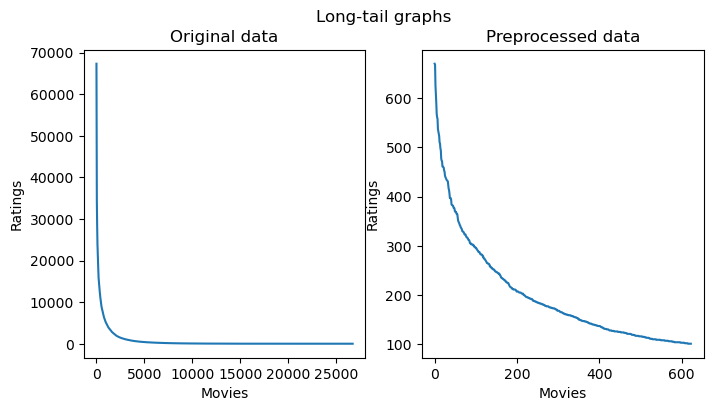

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle('Long-tail graphs')
axes[0].set_title('Original data')
axes[0].set_xlabel('Movies')
axes[0].set_ylabel('Ratings')
axes[1].set_title('Preprocessed data')
axes[1].set_xlabel('Movies')
axes[1].set_ylabel('Ratings')
sns.lineplot(ax=axes[0], x = range(len(data_ratings_or)), y = data_ratings_or)
sns.lineplot(ax=axes[1], x = range(len(data_ratings_pr)), y = data_ratings_pr)
fig.savefig('long-tail.png')

## Preprocessing
* Preprocessed data for both content-based and colloborative filtering systems.
* Updates the precalculated dataframes.

In [37]:
print("Prerocessing for Collaborative Filtering Recommender...")
from data_script.preprocess_collaborative import sveta_user_id, hamid_user_id
# import clustering_collaborative #TODO

Prerocessing for Collaborative Filtering Recommender...
Creating raw dataframes...
Creating dataframes with Sveta and Hamid ratings...
Creating dataframes with anti-Sveta and anti-Hamid ratings...
Creating new ratings dataframe for collaborative filtering ...
Out of total of  138493  users,  64051  are considered lazy and will be removed.
The final number of users is  74442
Randomly choosing 1000 users...
Adding Sviatlana's and Hamid's ratings... we are lazy users, but still...
Sveta 's user id is 86968
Hamid 's user id is 27844
Adding anti-Sviatlana's and anti-Hamid's ratings... they are lazy users, but still...
anti-Sveta 's user id is 8633
anti-Hamid 's user id is 73687
Now, the final number of users is  1004
Filtering movies...
Out of total of  9486  movies,  8863  are considered rare and will be removed.
The final number of movies is  623
Creating the pivot matrix...
The resulting sparcity of the matrix is: 0.8019191292614454
Preparing the final rating matrix...
Data preprocesssin

In [4]:
#sveta_user_id, hamid_user_id # or use sveta and hamid's id (assigned randomly at the preprocessing step

In [5]:
print("Prerocessing for Content-Based Recommender...")
from data_script.preprocess_content_based import get_df_ContBaseRec
df_ContBaseRec = get_df_ContBaseRec()

Prerocessing for Content-Based Recommender...


/home/mumu/Documents/DS/movie_recommendation_ProjectCDS/data_script/preprocess_content_based.py:93: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)


## Train Nearest Neighbor CB model

In [2]:
nn = CBR.train_nearest_neighbors_model()

## Training and saving CF models

In [8]:
trainset, testset, data, algo, algo_predictions, knn, knn_predictions = train_cf_models()

Getting the ratings matrix...
Preparing data in the Suprise format...
Training and saving a KNN model for calculating the CF model weights in hybrid setup..
Mean CV RMSE is 0.837
Training KNN-based memory based model for hybrid...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Mean CV RMSE is 0.933
Training is done!


## Content-based recommender

In [5]:
cb_recommender = ContentBasedRecommender()

In [ ]:
# Run to recomputer the CBMatrix
start_time = time.time()
cb_recommendations = get_CBMatrix()
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)
cb_recommendations.head()

In [7]:
# Get the CBMatrix
#cb_recommender = ContentBasedRecommender()
cb_recommendations = cb_recommender.df_recommendations

In [9]:
userId = 86968
cb_recommender.recommendation(userId, 20)

,movieId,score,title,genres
0,678,0.916408,Some Folks Call It a Sling Blade (1993),Drama|Thriller
1,1276,0.898239,Cool Hand Luke (1967),Drama
2,3681,0.887929,For a Few Dollars More (Per qualche dollaro in...,Action|Drama|Thriller|Western
3,1209,0.882586,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western
4,8340,0.880683,Escape from Alcatraz (1979),Drama|Thriller
5,104069,0.880032,Louis C.K.: Oh My God (2013),Comedy
6,56782,0.879797,There Will Be Blood (2007),Drama|Western
7,1358,0.878825,Sling Blade (1996),Drama
8,1201,0.878284,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
9,2692,0.875562,Run Lola Run (Lola rennt) (1998),Action|Crime


In [18]:
#since the final rating and cb_recommendation matrix do reset_indexve the same set of users, we can only test the 
set_of_test_users = set(cb_recommendations.userId.values).intersection(set(ratings.userId.unique()))
print(len(set_of_test_users))

1004


## User-based colloborative filtering recommender

In [3]:
cf_model = CFR.CollaborativeFilteringRecommender()
cf_model.recompute_surprise_data()
cf_model.fit_and_predict()

Getting the ratings matrix...
Preparing data in the Suprise format...
Done calculating predictions and scores!


In [5]:
random_user = np.random.choice(ratings.userId.unique()) # picks a random user
cf_model.recommend(sveta_user_id, n1 = 20, n2 = 10)

,userId,movieId,rating,title,genres,avg_rating,amnt_rating,amnt_rating_inverse,cf_score
0,86968,2858,4.808932,American Beauty (1999),Comedy|Drama,4.155934,44987.0,0.000011,1.000000
1,86968,47,4.723710,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,4.053493,43249.0,0.000012,0.969631
2,86968,1263,4.721342,"Deer Hunter, The (1978)",Drama|War,3.986663,10572.0,0.000047,0.968788
3,86968,246,4.711872,Hoop Dreams (1994),Documentary,4.042897,10432.0,0.000048,0.965413
4,86968,1304,4.661925,Butch Cassidy and the Sundance Kid (1969),Action|Western,4.053638,15558.0,0.000032,0.947615
5,86968,2502,4.658750,Office Space (1999),Comedy|Crime,3.985390,20328.0,0.000025,0.946483
6,86968,904,4.652137,Rear Window (1954),Mystery|Thriller,4.271334,17449.0,0.000029,0.944127
7,86968,1230,4.641210,Annie Hall (1977),Comedy|Romance,4.081259,15383.0,0.000033,0.940233
8,86968,5464,4.620794,Road to Perdition (2002),Crime|Drama,3.685840,8284.0,0.000060,0.932958
9,86968,2997,4.615052,Being John Malkovich (1999),Comedy|Drama|Fantasy,3.953203,27160.0,0.000018,0.930912


In [6]:
cf_model.recommend(sveta_user_id, n1 = 20, n2 = 10, version =1)

,userId,movieId,rating,title,genres,avg_rating,amnt_rating,amnt_rating_inverse,cf_score
3,86968,246,0.709775,Hoop Dreams (1994),Documentary,0.619406,0.074287,0.679643,2.008824
2,86968,1263,0.738092,"Deer Hunter, The (1978)",Drama|War,0.525716,0.078038,0.667925,1.931733
6,86968,904,0.531156,Rear Window (1954),Mystery|Thriller,1.000000,0.262270,0.323817,1.854973
0,86968,2858,1.000000,American Beauty (1999),Comedy|Drama,0.807735,1.000000,0.000000,1.807735
13,86968,51255,0.286356,Hot Fuzz (2007),Action|Comedy|Crime|Mystery,0.324858,0.000000,1.000000,1.611213
4,86968,1304,0.560424,Butch Cassidy and the Sundance Kid (1969),Action|Western,0.637302,0.211611,0.388114,1.585840
7,86968,1230,0.498484,Annie Hall (1977),Comedy|Romance,0.683320,0.206922,0.394863,1.576667
1,86968,47,0.745171,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0.637060,0.953440,0.008245,1.390476
8,86968,5464,0.437437,Road to Perdition (2002),Crime|Drama,0.024522,0.016743,0.909073,1.371032
12,86968,5902,0.287097,Adaptation (2002),Comedy|Drama|Romance,0.289848,0.046185,0.778564,1.355509


## Hybrid recommender

In [10]:
hyb_recommender = HybridRecommender()

Getting the ratings matrix...
Preparing data in the Suprise format...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# Run to recomputer the HRMatrix
start_time = time.time()
hyb_recommendations = get_HRMatrix()
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)
hyb_recommendations.head()

Getting the ratings matrix...
Preparing data in the Suprise format...


In [9]:
# Get the HRMatrix
hyb_recommendations = hyb_recommender.df_recommendations
hyb_recommendations.head()

,userId,1,2,3,4,5,6,7,8,9,...,130075,130087,130490,130496,130520,130578,130840,131013,131168,131170
0,73687,NaN,0.578596,0.698370,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8633,NaN,NaN,0.621519,NaN,NaN,0.879630,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27844,NaN,0.727339,0.857257,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86968,NaN,NaN,0.658183,NaN,NaN,0.952319,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,186,NaN,0.807884,0.843629,NaN,0.777431,0.699742,0.779235,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
userId = 186
hyb_recommender.hybrid_recommendation(userId, 10)

,movieId,hybrid_score,title,genres
0,2804,0.898999,"Christmas Story, A (1983)",Children|Comedy
1,1302,0.886882,Field of Dreams (1989),Children|Drama|Fantasy
2,1663,0.879334,Stripes (1981),Comedy|War
3,3039,0.868052,Trading Places (1983),Comedy
4,2407,0.864951,Cocoon (1985),Comedy|Sci-Fi
5,2716,0.862157,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi
6,802,0.860390,Phenomenon (1996),Drama|Romance
7,2797,0.855233,Big (1988),Comedy|Drama|Fantasy|Romance
8,1573,0.852268,Face/Off (1997),Action|Crime|Drama|Thriller
9,529,0.851700,Searching for Bobby Fischer (1993),Drama


# Evaluation of the different recommenders


## Accuracy of the collaborative system
* metrics: rmse
* method: cross-validation


In [4]:
cf_model.fit_and_predict()
cf_model.cross_validate()

Getting the ratings matrix...
Preparing data in the Suprise format...
Done calculating predictions and scores!
Cross Validating the data...
Mean CV RMSE is 0.832


0.832

## Coverage
The measure represents the averaged percentage of all the movies recommended to all the users.

In [15]:
evaluate = Evaluate()

...Loading Content Based Recommender..
...Loading Hybrid Recommender..
Getting the ratings matrix...
Preparing data in the Suprise format...
Computing the pearson similarity matrix...
Done computing similarity matrix.
...Loading Collaborative Filtering Recommender..
Getting the ratings matrix...
Preparing data in the Suprise format...


In [3]:
cov_cf, cov_cf_perc = evaluate.variety_collaborative_filtering(version=0)
print("Collaborative filtering, version 0:",cov_cf, round(cov_cf_perc,0), "%.")

Collaborative filtering, version 0: 428.0 69.0 %.


In [4]:
cov_cf, cov_cf_perc = evaluate.variety_collaborative_filtering(version=1)
print("Collaborative filtering, version 1:", cov_cf, round(cov_cf_perc,0), "%")

Collaborative filtering, version 1: 428.0 69.0 %


In [11]:
cov_cb, cov_cb_perc = evaluate.variety_content_based()
print("Content-based:", cov_cb, round(cov_cb_perc,0), "%")

Content-based: 572.0 6.0 %


In [1]:
572 * 100/ 623

91.81380417335474

In [12]:
cov_hyb, cov_hyb_perc = evaluate.variety_hybrid()
print("Hybrid:", cov_hyb, cov_hyb_perc)

Hybrid: 409.0 4.0


In [2]:
409 * 100 / 623

65.65008025682182

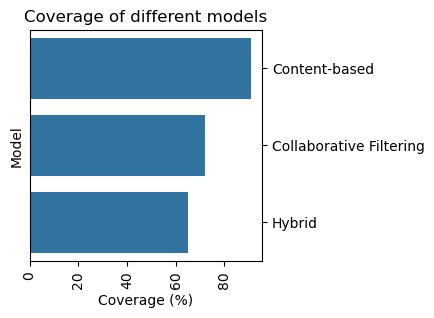

In [13]:
df = pd.DataFrame({
    "Model": ['Collaborative Filtering','Content-based', 'Hybrid'],
    "Coverage (%)": [72, 91, 65],
    "Boolean": 100
}).sort_values(by = "Coverage (%)", ascending = False)
plt.figure(figsize=(3, 3))
plt.xticks(rotation=90)
plt.title("Coverage of different models")
g = sns.barplot(y = "Model", x = "Coverage (%)", hue = "Boolean", data = df)
g.yaxis.set_ticks_position("right")
g.legend_.remove()

## Personalization
A personalised system is expected to suggest different movies for dissimilar users.

Mertic: overlap between suggestions for different users.

Similarity is taken from various similarity matrices.

In [16]:
#evaluate = Evaluate()
evaluate.compute_surprise_similarity()

...Computing KNN similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [17]:
result_cf = evaluate.personalisation('cf')

In [18]:
result_cb = evaluate.personalisation('cb')

In [19]:
result_hyb = evaluate.personalisation('hyb')

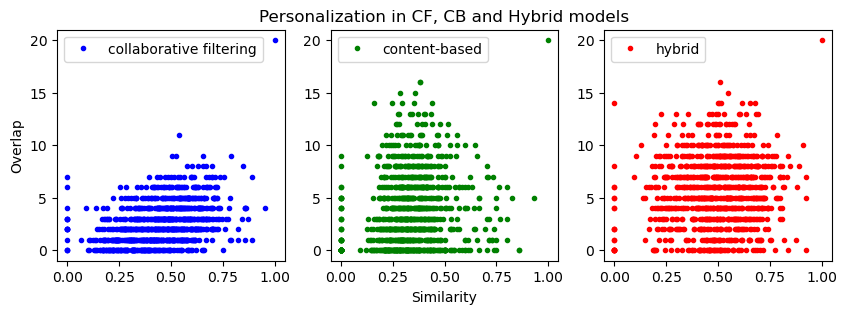

In [35]:
fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(3)

ax=fig.add_subplot(131)
ax.set_ylabel('Overlap')
ax.plot(result_cf.similarity, result_cf.overlap, "b.", linewidth=0.2, label="collaborative filtering")
ax.legend()
ax=fig.add_subplot(132)
ax.set_title("Personalization in CF, CB and Hybrid models")
ax.plot(result_cb.similarity,result_cb.overlap, "g.", linewidth=0.2, label="content-based")
ax.legend()
ax.set_xlabel('Similarity')
ax=fig.add_subplot(133)
ax.plot(result_hyb.similarity, result_hyb.overlap, "r.", linewidth=0.9, label="hybrid")
ax.legend()

In [ ]:
def return_sims_above_threshold(similarities_df, threshold):
    return len(similarities_df[similarities_df.similarity > threshold])